In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = 'plots/'
datadir='data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

start_date="2012-02-01"
end_date="2016-12-29"

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [3]:
cash_ticker = "_CASH"

In [4]:
sigmas[cash_ticker] = 0.
returns = returns.rename(columns={"USDOLLAR": cash_ticker})
volumes[cash_ticker] = np.finfo(np.float).max

In [5]:
w_b = pd.Series(index=returns.columns, data=1)
w_b._CASH = 0.
w_b/=sum(w_b)


In [6]:
return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [7]:
sigma_estimate[cash_ticker] = 0.
return_estimate = return_estimate.rename(columns={"USDOLLAR": cash_ticker})
volume_estimate[cash_ticker] = np.finfo(np.float).max

In [8]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

simulated_hcost=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
simulated_tcost=helium.TransactionCost(gamma =1.0, 
                                             half_spread=0.0005/2,
                                             nonlin_coef = 1.,
                                             sigmas = sigmas, 
                                             nonlin_power = 1.5,
                                             volumes = volumes,
                                             asym_coef = 0.)

simulator = helium.MarketSimulator(returns, volumes, costs=[
    simulated_tcost, 
    simulated_hcost
], cash_ticker=cash_ticker)

In [9]:
r_est_dict = {}
d_est_dict = {}
for day in return_estimate.index[:-1]:
    rrr = return_estimate.loc[day:].iloc[:2].copy()
    r_est_dict[day] = rrr
    deltas = rrr.copy()
    deltas[:] = 0.
    d_est_dict[day] = deltas

In [10]:
r= helium.DefaultReturns(r_est_dict,  d_est_dict , gamma_decay=None)
#Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [11]:
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [12]:
policies = {}
results = {}
gamma_risks_coarse=[.1,.3,1, 3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2., 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
           
            risk_model, 
                 optimization_tcost, 
                optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.MultiPeriodOpt(r, costs, const, 2)

In [13]:
results = {}
results.update(dict(zip(policies.keys(), simulator.run_multi(1E8*w_b, policies.values(), start_date, end_date, parallel=True ) ) ))

In [14]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[39.598157266668878, 38.738780475858, 35.919466432860276, 29.381625486975576, 18.353750742528433, 9.0922435457208817, 3.524638739903398, 1.4084778989587003, 0.4928006842332614] [17.54398352735085, 17.268697572136997, 16.75593633550422, 14.394886580862051, 11.647013369026691, 8.580829823584798, 4.247369454689815, 1.8962784508654325, 0.6781554271576403]
[38.38050759078785, 36.642045987166554, 31.564171641720559, 23.712955653762712, 13.335816771359172, 6.4052689112389842, 2.5929608581166375, 1.0809783936178974, 0.40604380878051938] [39.596547364146005, 35.912737371683924, 27.67043375822171, 21.05430389336432, 14.132183785536052, 8.032874201445189, 3.750348262220091, 1.6346642760982284, 0.5879357405007638]
[32.755671808187245, 29.662336827293281, 22.169781923243711, 13.708301836746367, 7.4935170515635692, 3.6947172764241176, 1.5767548513561263, 0.69859063935882126, 0.28583517625152782] [30.037991374564545, 26.71362247373146, 22.512180437833152, 13.939093409997078, 8.34437364267353, 5.06166

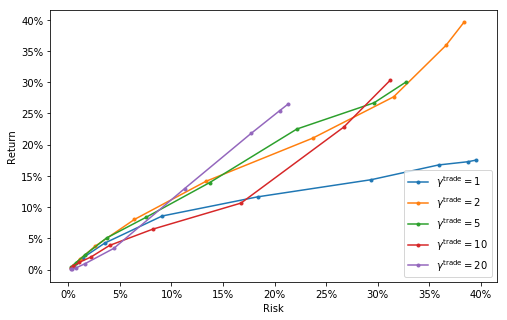

In [15]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine Search

In [ ]:
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine:
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
           
            risk_model, 
                 optimization_tcost, 
                optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.MultiPeriodOpt(r, costs, const, 2)

results.update(dict(zip(policies.keys(), simulator.run_multi(1E8*w_b, policies.values(), start_date, end_date, parallel=True ) ) ) )

In [ ]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

In [ ]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

### Pareto

In [ ]:
policies = {}
#results = {}
gamma_risks_pareto=[1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[7,8,9,10,11,12]
gamma_holdings=[.1,1.,10., 100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            
            
            risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
            optimization_hcost = helium.HoldingCost(gamma = gamma_holding, borrow_costs=borrow_costs, dividends=dividends)
            optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
            # issue optimization_tcost
            costs = [ risk_model,                  optimization_tcost,                 optimization_hcost                ]
            const = [helium.LeverageLimitConstraint(3)]
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = helium.MultiPeriodOpt(r, costs, const, 2)

        
results_pareto = {}
results_pareto.update(dict(zip(policies.keys(), simulator.run_multi(1E8*w_b, policies.values(), start_date, end_date, parallel=True ) ) ) ) 

In [ ]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]

table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'mpo_pareto_results.csv', float_format='%g')

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'mpo_pareto.png')

In [ ]:
xlim=20
ylim=30
tableprint=table[table.is_pareto]
tableprint=tableprint[tableprint.Risk <= xlim]
tableprint=tableprint[tableprint.Return <= ylim]
del tableprint['is_pareto']
tableprint.Risk=tableprint.Risk.apply(lambda x: '%.2f%%'%x)
tableprint.Return=tableprint.Return.apply(lambda x: '%.2f%%'%x)
print(tableprint.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

In [ ]:
table_spo = pd.read_csv(datadir + 'spo_pareto_results.csv', index_col=0)

plt.figure(figsize=(8,5))

plt.plot(table[table.is_pareto].Risk, table[table.is_pareto].Return, 'C3.-', label='MPO pareto frontier')

plt.plot(table_spo[table_spo.is_pareto].Risk,
         table_spo[table_spo.is_pareto].Return, 'C2.-', label='SPO pareto frontier')
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

In [ ]:
table